#### In this notebook, we show how to prepare the training and test datasets for DLNs.

#### The processed datasets and related information will be saved in the data/datasets/NAME/seed_{SEED}/data directory:
- `train.csv` and `test.csv` (store features and the target class).
- `data_info.json` (stores dataset information such as feature data types and scaling).

#### The columns of the datasets should follow these standards:
- Features should be ordered as categorical features, then continuous features, then the target.
- Features should be scaled between 0 and 1.
- The target column should be named “Target” and labeled from 0 up to (num_classes – 1).
- Try to avoid using characters other than letters or underscores in feature names.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from data.data_utils import *
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [2]:
# Read dataset

# Download the dataset ZIP to example/data_raw/Heart/
!mkdir -p example/data_raw/Heart
!curl -L -o example/data_raw/Heart/heart-disease-cleveland-uci.zip \
  https://www.kaggle.com/api/v1/datasets/download/cherngs/heart-disease-cleveland-uci

# Unzip
!unzip -o example/data_raw/Heart/heart-disease-cleveland-uci.zip -d example/data_raw/Heart/
!rm example/data_raw/Heart/heart-disease-cleveland-uci.zip

# Read the .csv file
datapath = 'example/data_raw/Heart/heart_cleveland_upload.csv'
df = pd.read_csv(datapath)
# df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3405  100  3405    0     0   9920      0 --:--:-- --:--:-- --:--:--     0
Archive:  example/data_raw/Heart/heart-disease-cleveland-uci.zip
  inflating: example/data_raw/Heart/heart_cleveland_upload.csv  


In [3]:
# Check for missing values

print(df.isnull().sum().sum())

0


In [4]:
# Preprocessing columns

# Make categorical features one-hot
# print('cp:', np.unique(df["cp"], return_counts=True))
# print('restecg:', np.unique(df["restecg"], return_counts=True))
# print('slope:', np.unique(df["slope"], return_counts=True))
# print('thal:', np.unique(df["thal"], return_counts=True))
# print('ca:', np.unique(df["ca"], return_counts=True))

df.drop(df[df["restecg"]==1].index, inplace=True)
oh_list = ["cp", "restecg", "slope", "thal", "ca"]
for _f in oh_list:
    df[_f] = df[_f].astype('object')
one_hot_df = pd.get_dummies(df[oh_list], drop_first=True)
df = df.drop(oh_list, axis=1)
df = df.join(one_hot_df)

df.reset_index(inplace=True, drop=True)

# Assign the column name of the target feature as "Target"
df.rename(columns={"condition":"Target"}, inplace=True)

print('\ndata shape: ', df.shape, sep='')
print('\nclass distribution:\n', df.Target.value_counts(), sep='')
# print('\ncolumn types:\n', df.dtypes, sep='')


data shape: (293, 20)

class distribution:
Target
0    159
1    134
Name: count, dtype: int64


In [5]:
# Sort features into the [categorical, continuous, target] order

continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = list(OrderedSet(df.columns.to_list()) - OrderedSet(["Target"]) - OrderedSet(continuous_features))
print('continuous_features:', continuous_features)
print('\ncategorical_features:', categorical_features)

# Reindex columns to [cat, con, label]
df = df.reindex(columns=categorical_features+continuous_features+['Target'], copy=False)

dtype_dict = df.dtypes.to_dict()

continuous_features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

categorical_features: ['sex', 'fbs', 'exang', 'cp_1', 'cp_2', 'cp_3', 'restecg_2', 'slope_1', 'slope_2', 'thal_1', 'thal_2', 'ca_1', 'ca_2', 'ca_3']


In [6]:
# Shuffle and split data into train/(val)/test
seed = 0

train_fraction = 0.75 ###
df_train, df_test = shuffle_split_data(df, train_fraction, seed=seed)

print('train:', df_train.shape)
print(np.unique(df_train.Target, return_counts=True))
print('\ntest:', df_test.shape)
print(np.unique(df_test.Target, return_counts=True))

train: (219, 20)
(array([0, 1]), array([119, 100]))

test: (74, 20)
(array([0, 1]), array([40, 34]))


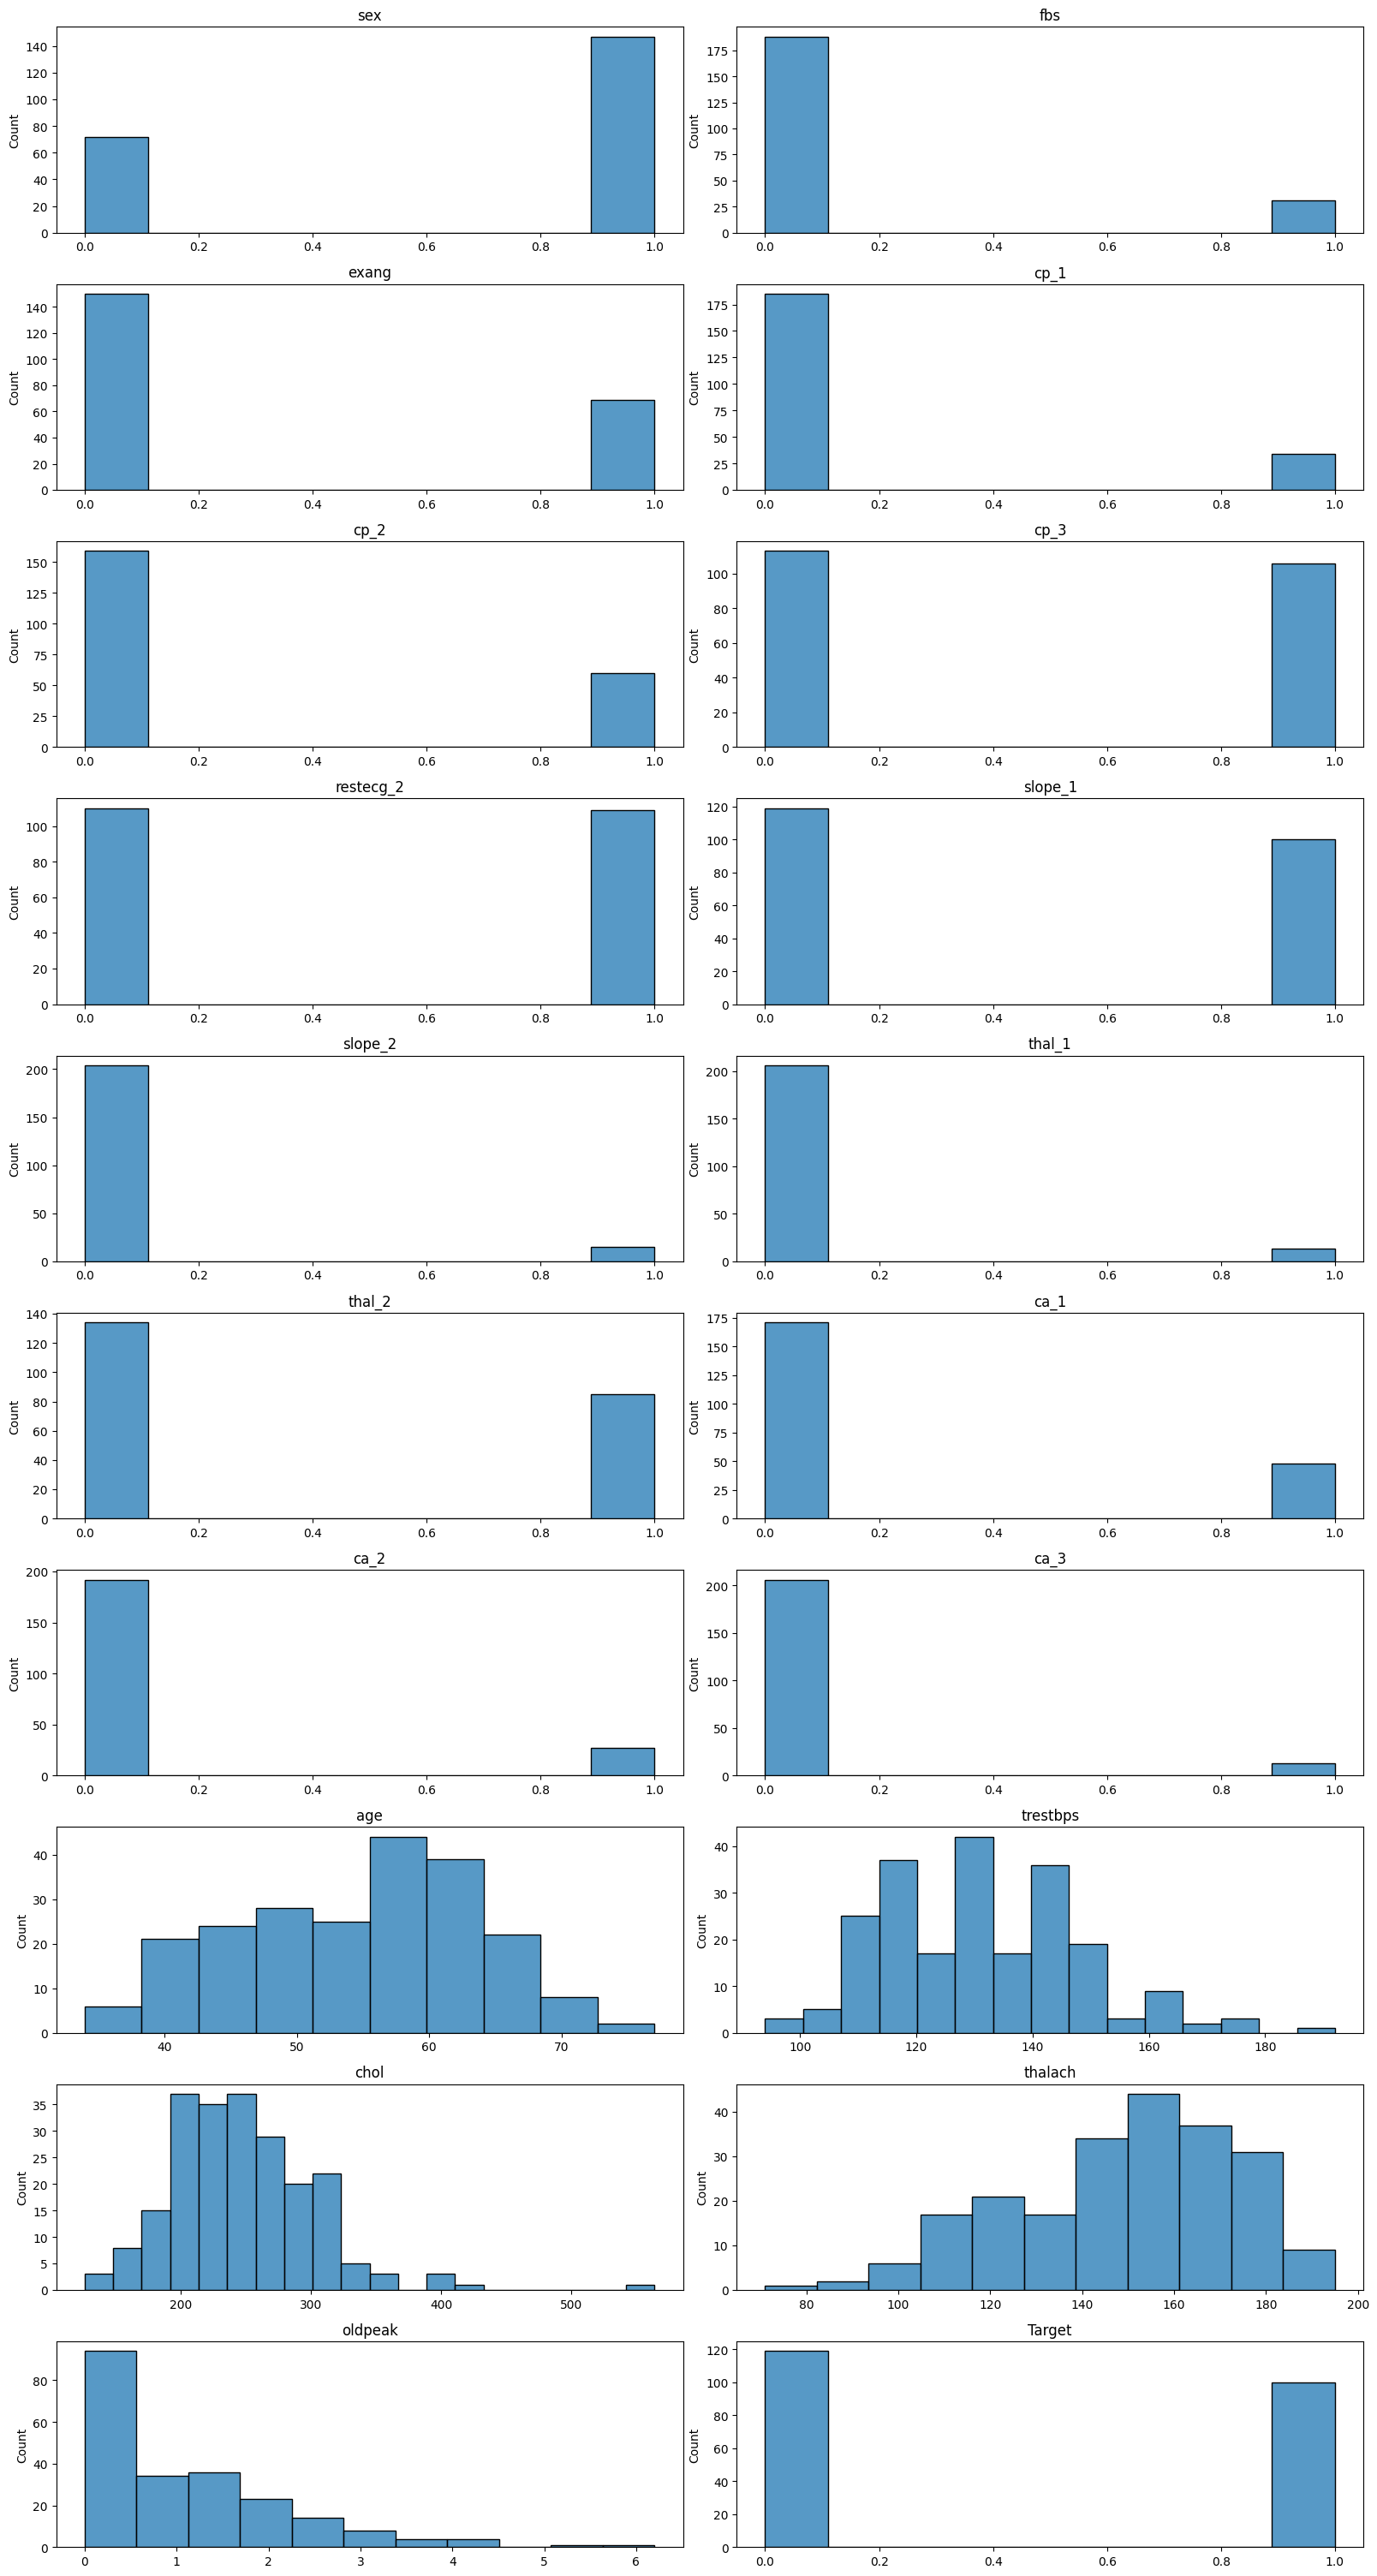

In [7]:
# Plot histograms of the training data

ncol, nrow = 2, int(np.ceil(len(df_train.columns)/2))
figsize = (16,3*nrow)

plot_hist(df_train, figsize, nrow, ncol)

In [8]:
# Feature outlier clipping and [0, 1] scaling

for feature in continuous_features:
    lower = np.percentile(df_train[feature], 0.5)
    upper = np.percentile(df_train[feature], 99.5)

    df_train.loc[df_train[feature]<lower, feature] = lower
    df_train.loc[df_train[feature]>upper, feature] = upper
    df_test.loc[df_test[feature]<lower, feature] = lower
    df_test.loc[df_test[feature]>upper, feature] = upper

scaler_list = [MinMaxScaler(clip=True), MinMaxScaler(clip=True)]
feature_list = [continuous_features, categorical_features]
df_train_scaled, df_test_scaled, scaler_params = scale_features(df_train, df_test, feature_list, scaler_list)

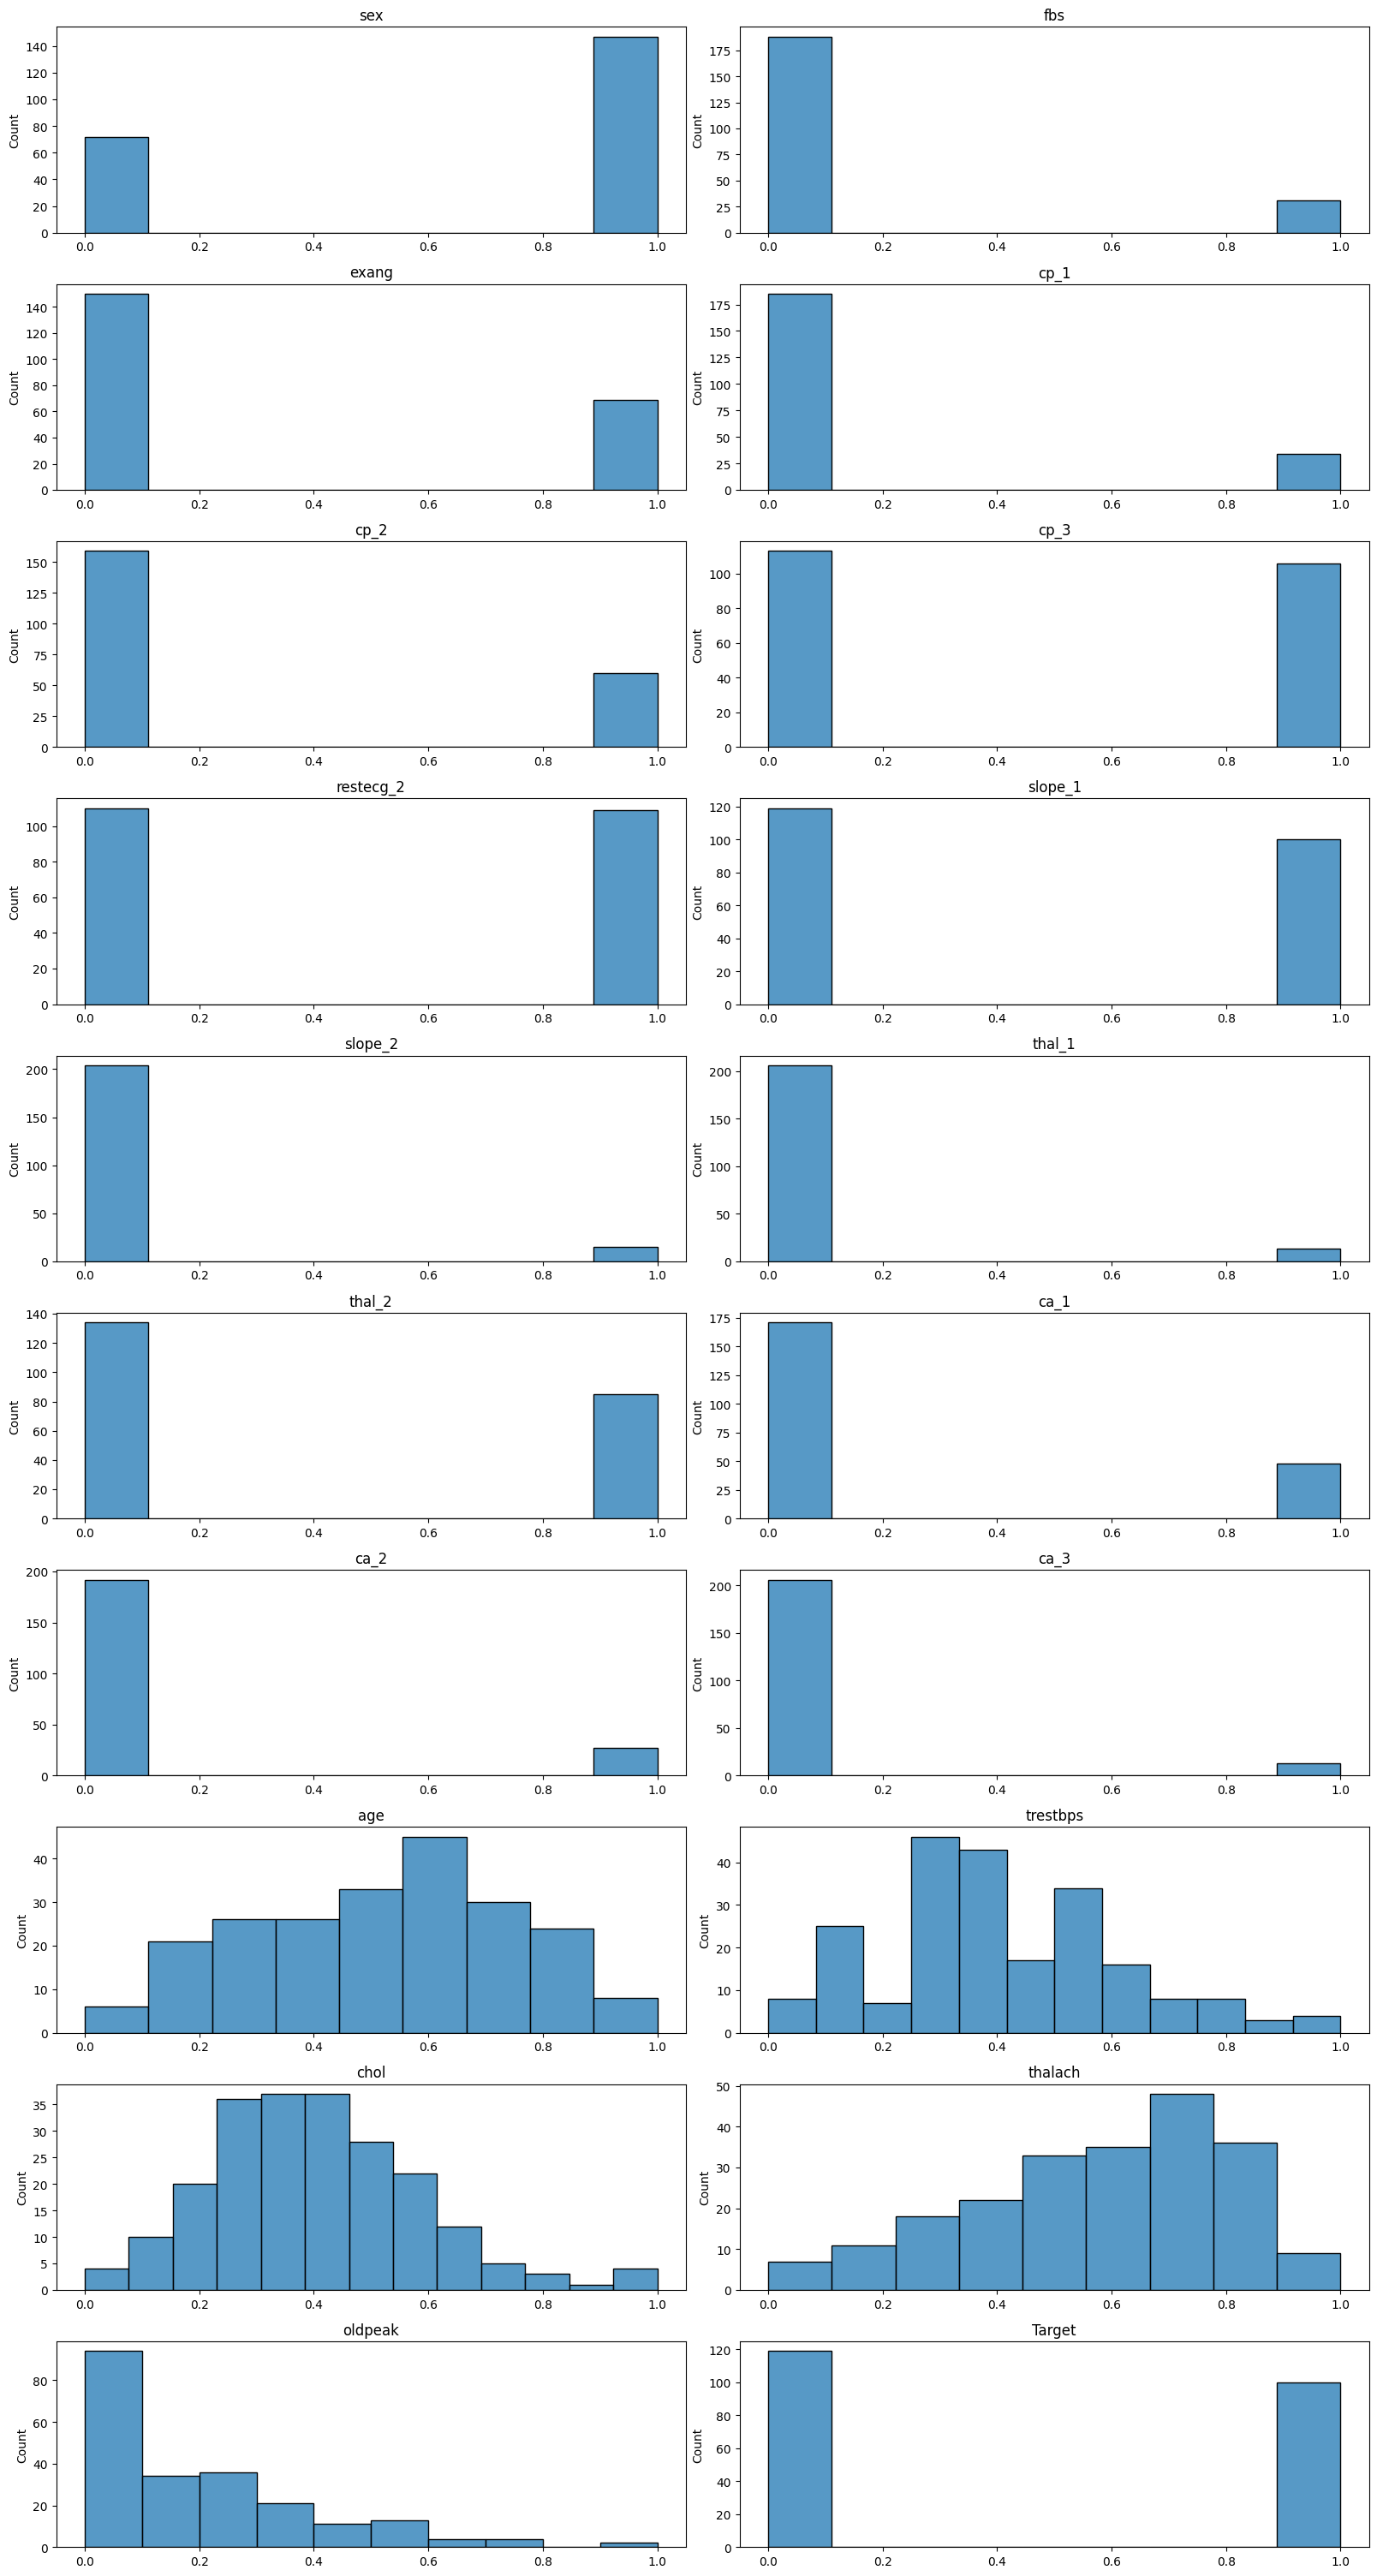

In [9]:
# Plot the scaled training data

plot_hist(df_train_scaled, figsize, nrow, ncol)

In [10]:
# Save the processed data and feature information

# Save data into the data/datasets/Heart/seed_0/data directory
# scaler_params and dtype_dict are used for network visualization
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
folderpath = f'{parent_dir}/data/datasets/Heart/seed_{seed}/data'
save_data(folderpath, continuous_features, categorical_features, scaler_params, dtype_dict, df_train_scaled, df_test_scaled)